# Deep Image Prior (DIP) for PAM - Batch Mode Only
## Tri Vu - Updated 051620

### Import libs and utils

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
from define_model import *
from build_unet import *
from utils import *
from keras.optimizers import Adam
import os
from os.path import isfile, join
from numba import cuda

Using TensorFlow backend.


In [2]:
""" Choose which gpu to run the training """
gpu = 1  # 0 for first gpu, 1 for 2nd gpu
if gpu == 0:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif gpu == 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Step 1: Mode Selection

In [3]:
BATCH_MODE = True  # Run DIP on a set of data for evaluation

SAVE_MODEL = True  # Save trained model and input noise
SAVE_LOSS = True
SAVE_OUTPUT = True  # Save auxillary info (training time and noise reg) output image, 
                    # with corrected image in the 2nd channel

### Step 2: Params Input and Pre-processing

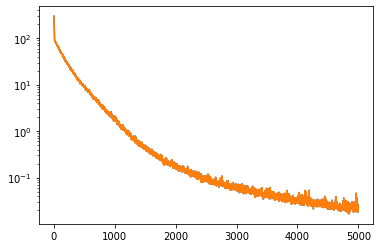

(array([4846, 4846], dtype=int64), array([0, 1], dtype=int64))

In [8]:
imgpath = './Data/10_5/output/'
imgname = '20190423_thinnedskull_Epi 11_Image1_index0_pad_5-10'
im = cv2.imread(imgpath + imgname + '_dip_out.png')
l = np.loadtxt(imgpath + imgname + '_loss.txt')

plt.plot(l)
plt.yscale('log')
plt.show()

np.where(l==np.min(l))